In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
import random
from makemore import (
    PytorchifiedBatchNorm,
    Sequential,
    Embedding,
    Flatten,
    Linear,
    Tanh,
    BatchNorm1d,
    load_words,
)

%matplotlib inline

In [2]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = (
    8  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [5]:
train_words, dev_words, test_words = load_words()

In [6]:
pytorchified = PytorchifiedBatchNorm(
    sizes=[200],
    batchnorm_output=False,
    block_size=block_size,
    flatten_consecutive=False,
)
model = Sequential(pytorchified.layers)

In [7]:
lossi, ud = pytorchified.train(train_words)

Epoch 0 Loss: 2.3604238358353875
Epoch 1 Loss: 2.24524418275217
Epoch 2 Loss: 2.204228181152056
Epoch 3 Loss: 2.176491432554744
Epoch 4 Loss: 2.1574577839672826
Epoch 5 Loss: 2.1422500884162687
Epoch 6 Loss: 2.1309116317590386
Epoch 7 Loss: 2.1207326957271233
Epoch 8 Loss: 2.11278744519102
Epoch 9 Loss: 2.105834266348332
Epoch 10 Loss: 2.0996440551765847
Epoch 11 Loss: 2.0937576387446897
Epoch 12 Loss: 2.0883131815396103
Epoch 13 Loss: 2.083166163372228
Epoch 14 Loss: 2.0808277549733614
Epoch 15 Loss: 2.0762589259573527
Epoch 16 Loss: 2.072572191026383
Epoch 17 Loss: 2.071725367788558
Epoch 18 Loss: 2.0663940033006507
Epoch 19 Loss: 2.0639861574673324
Epoch 20 Loss: 2.0610306200426405
Learning rate reduced to 0.01
Epoch 21 Loss: 1.9935720610940721
Epoch 22 Loss: 1.9877842859670476
Epoch 23 Loss: 1.9857027502222258
Epoch 24 Loss: 1.984542143200548
Epoch 25 Loss: 1.982829546840552
Epoch 26 Loss: 1.9826531732138843
Epoch 27 Loss: 1.982114609657076
Epoch 28 Loss: 1.9811019197140352
Epoch 2

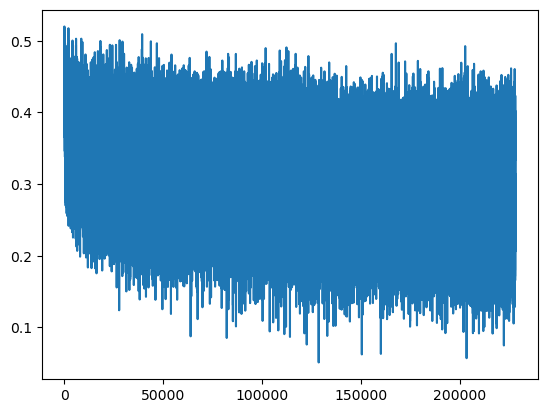

In [8]:
plt.plot(lossi)

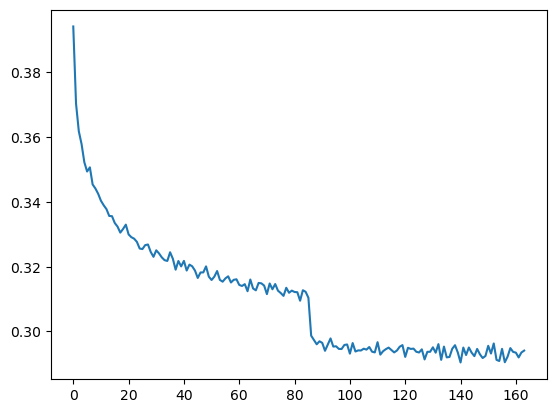

In [9]:
plt.plot(torch.tensor(lossi).view(-1, 1390).mean(1))

In [10]:
print(pytorchified.evaluate(train_words))
print(pytorchified.evaluate(dev_words))
print(pytorchified.evaluate(test_words))

1.9307647943496704
2.03131365776062
2.013676166534424


In [11]:
for _ in range(20):
    print(pytorchified.forward())

cemanciah
labelle
geovanie
maddied
ruhamoula
inyah
joana
sinan
ajustand
canaya
azamiah
lilzion
bertie
hanslyn
emmi
aseiah
jakaiyah
yana
sahlin
zaydone


In [12]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0, 16, 18, 21,  4,  5, 14,  3],
        [ 0,  8, 15, 19,  1, 14, 14,  1],
        [ 0,  0, 25,  5,  3,  8,  9,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [13]:
# Embedding layer
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [14]:
# Flatten layer
model.layers[1].out.shape

torch.Size([4, 80])

In [15]:
# Linear layer
model.layers[2].out.shape

torch.Size([4, 200])

In [16]:
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])